# 使用LSTM分类IMDB数据集

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
import os
import glob

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据集类，用于加载和处理数据
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        """
        初始化数据集类
        :param texts: 文本数据列表
        :param labels: 标签列表（0代表正面，1代表负面）
        :param vocab: 词汇表，映射单词到索引
        """
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
    
    def __len__(self):
        return len(self.labels)  # 返回数据集的大小
    
    def __getitem__(self, idx):
        """
        获取指定索引的数据样本
        :param idx: 数据索引
        :return: 文本对应的张量和标签
        """
        text = [self.vocab[word] for word in self.texts[idx] if word in self.vocab]  # 将文本转换为索引列表
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# 数据预处理函数，读取数据并分词
def preprocess_data(data_dir):
    """
    预处理数据：读取文本数据并分词
    :param data_dir: 数据文件夹路径
    :return: 分词后的文本和标签
    """
    texts = []
    labels = []
    for label in ["pos", "neg"]:
        # 获取正面和负面评论的文件路径
        file_paths = glob.glob(os.path.join(data_dir, label, "*.txt"))
        for file_path in file_paths:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
                texts.append(text.lower().split())  # 分词并转小写
                labels.append(0 if label == "pos" else 1)  # 标签：正面为0，负面为1
    return texts, labels

# 定义 LSTM 模型
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes):
        """
        初始化 LSTM 分类器
        :param vocab_size: 词汇表大小
        :param embed_dim: 嵌入层维度
        :param hidden_dim: LSTM 隐藏层维度
        :param num_layers: LSTM 层数
        :param num_classes: 分类数目（2类：正面或负面）
        """
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # 嵌入层
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)  # LSTM层
        self.fc = nn.Linear(hidden_dim, num_classes)  # 全连接层，用于分类
    
    def forward(self, text, lengths):
        """
        前向传播：文本数据经过嵌入层、LSTM层和全连接层
        :param text: 输入的文本数据（已转换为索引）
        :param lengths: 文本的实际长度
        :return: 分类结果
        """
        embedded = self.embedding(text)  # 将文本转换为嵌入向量
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)  # LSTM 层处理
        out = self.fc(hidden[-1])  # 使用最后一个时间步的隐藏状态作为分类的依据
        return out

# 超参数设置
embed_dim = 128  # 嵌入层维度
hidden_dim = 256  # LSTM 隐藏层维度
num_layers = 2  # LSTM 层数
num_classes = 2  # 二分类任务：正面或负面
batch_size = 64  # 批大小
num_epochs = 10  # 训练轮数
learning_rate = 0.001  # 学习率

# 数据路径设置
train_data_dir = "./aclImdb/train"  # 训练数据文件夹路径
test_data_dir = "./aclImdb/test"    # 测试数据文件夹路径

# 数据加载与处理
train_texts, train_labels = preprocess_data(train_data_dir)
test_texts, test_labels = preprocess_data(test_data_dir)

# 构建词汇表
vectorizer = CountVectorizer(max_features=10000)  # 使用CountVectorizer构建词汇表，最多包含10000个词
vectorizer.fit([" ".join(text) for text in train_texts])  # 根据训练集文本构建词汇表
vocab = {word: i+1 for i, word in enumerate(vectorizer.get_feature_names_out())}  # 词汇表映射：单词 -> 索引

# 划分数据集
train_dataset = IMDBDataset(train_texts, train_labels, vocab)
test_dataset = IMDBDataset(test_texts, test_labels, vocab)

# 定义 DataLoader，加载数据
def collate_fn(batch):
    """
    数据加载器的自定义合并函数，用于处理批数据
    :param batch: 当前批次的数据
    :return: 填充后的文本、标签和文本长度
    """
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # 填充文本
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels, lengths

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 模型初始化
vocab_size = len(vocab) + 1  # 加1以包含padding索引
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_layers, num_classes).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam优化器

# 训练模型
for epoch in range(num_epochs):
    model.train()  # 切换到训练模式
    total_loss, total_correct = 0, 0
    for texts, labels, lengths in train_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()  # 将lengths转回CPU
        
        optimizer.zero_grad()  # 梯度清零
        outputs = model(texts, lengths)  # 模型输出
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
        total_loss += loss.item()  # 累加损失
        total_correct += (outputs.argmax(1) == labels).sum().item()  # 计算正确预测数量
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader):.4f}, Accuracy: {total_correct/len(train_dataset):.4f}")

# 测试模型
model.eval()  # 切换到评估模式
total_correct = 0
with torch.no_grad():  # 不计算梯度，减少内存开销
    for texts, labels, lengths in test_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()  # 将lengths转回CPU
        outputs = model(texts, lengths)  # 模型输出
        total_correct += (outputs.argmax(1) == labels).sum().item()  # 累加正确预测数量

print(f"Test Accuracy: {total_correct/len(test_dataset):.4f}")


Using device: cuda


KeyboardInterrupt: 

# 使用正则化，学习率调度，双向LSTM后的完整代码

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
import os
import glob

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据集类，用于加载和处理数据
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        """
        初始化数据集类
        :param texts: 文本数据列表
        :param labels: 标签列表（0代表正面，1代表负面）
        :param vocab: 词汇表，映射单词到索引
        """
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
    
    def __len__(self):
        return len(self.labels)  # 返回数据集的大小
    
    def __getitem__(self, idx):
        """
        获取指定索引的数据样本
        :param idx: 数据索引
        :return: 文本对应的张量和标签
        """
        text = [self.vocab[word] for word in self.texts[idx] if word in self.vocab]  # 将文本转换为索引列表
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# 数据预处理函数，读取数据并分词
def preprocess_data(data_dir):
    """
    预处理数据：读取文本数据并分词
    :param data_dir: 数据文件夹路径
    :return: 分词后的文本和标签
    """
    texts = []
    labels = []
    for label in ["pos", "neg"]:
        # 获取正面和负面评论的文件路径
        file_paths = glob.glob(os.path.join(data_dir, label, "*.txt"))
        for file_path in file_paths:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
                texts.append(text.lower().split())  # 分词并转小写
                labels.append(0 if label == "pos" else 1)  # 标签：正面为0，负面为1
    return texts, labels

# 定义 LSTM 模型
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        """
        初始化 LSTM 分类器
        :param vocab_size: 词汇表大小
        :param embed_dim: 嵌入层维度
        :param hidden_dim: LSTM 隐藏层维度
        :param num_layers: LSTM 层数
        :param num_classes: 分类数目（2类：正面或负面）
        :param dropout: Dropout正则化
        """
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # 嵌入层
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)  # LSTM层
        self.fc = nn.Linear(hidden_dim, num_classes)  # 全连接层，用于分类
        self.dropout = nn.Dropout(dropout)  # Dropout层，用于减少过拟合
    
    def forward(self, text, lengths):
        """
        前向传播：文本数据经过嵌入层、LSTM层和全连接层
        :param text: 输入的文本数据（已转换为索引）
        :param lengths: 文本的实际长度
        :return: 分类结果
        """
        embedded = self.embedding(text)  # 将文本转换为嵌入向量
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)  # LSTM 层处理
        out = self.fc(self.dropout(hidden[-1]))  # 使用最后一个时间步的隐藏状态作为分类的依据
        return out

# 超参数设置
embed_dim = 128  # 嵌入层维度
hidden_dim = 256  # LSTM 隐藏层维度
num_layers = 3  # LSTM 层数
num_classes = 2  # 二分类任务：正面或负面
batch_size = 128  # 批大小
num_epochs = 40  # 训练轮数
learning_rate = 0.001  # 学习率

# 数据路径设置
train_data_dir = "./aclImdb/train"  # 训练数据文件夹路径
test_data_dir = "./aclImdb/test"    # 测试数据文件夹路径

# 数据加载与处理
train_texts, train_labels = preprocess_data(train_data_dir)
test_texts, test_labels = preprocess_data(test_data_dir)

# 构建词汇表
vectorizer = CountVectorizer(max_features=10000)  # 使用CountVectorizer构建词汇表，最多包含10000个词
vectorizer.fit([" ".join(text) for text in train_texts])  # 根据训练集文本构建词汇表
vocab = {word: i+1 for i, word in enumerate(vectorizer.get_feature_names_out())}  # 词汇表映射：单词 -> 索引

# 划分数据集
train_dataset = IMDBDataset(train_texts, train_labels, vocab)
test_dataset = IMDBDataset(test_texts, test_labels, vocab)

# 定义 DataLoader，加载数据
def collate_fn(batch):
    """
    数据加载器的自定义合并函数，用于处理批数据
    :param batch: 当前批次的数据
    :return: 填充后的文本、标签和文本长度
    """
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # 填充文本
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels, lengths

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 模型初始化
vocab_size = len(vocab) + 1  # 加1以包含padding索引
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_layers, num_classes).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam优化器

# 定义学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# 训练模型
for epoch in range(num_epochs):
    model.train()  # 切换到训练模式
    total_loss, total_correct = 0, 0
    for texts, labels, lengths in train_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()  # 将lengths转回CPU
        
        optimizer.zero_grad()  # 梯度清零
        outputs = model(texts, lengths)  # 模型输出
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
        total_loss += loss.item()  # 累加损失
        total_correct += (outputs.argmax(1) == labels).sum().item()  # 计算正确预测数量
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader):.4f}, Accuracy: {total_correct/len(train_dataset):.4f}")
    
    # 更新学习率
    scheduler.step(total_loss)

# 测试模型
model.eval()  # 切换到评估模式
total_correct = 0
with torch.no_grad():  # 不计算梯度，减少内存开销
    for texts, labels, lengths in test_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()  # 将lengths转回CPU
        outputs = model(texts, lengths)  # 模型输出


Using device: cuda
Epoch 1/40, Loss: 0.6574, Accuracy: 0.6108
Epoch 2/40, Loss: 0.5717, Accuracy: 0.7062
Epoch 3/40, Loss: 0.4815, Accuracy: 0.7790
Epoch 4/40, Loss: 0.4217, Accuracy: 0.8144
Epoch 5/40, Loss: 0.3708, Accuracy: 0.8439
Epoch 6/40, Loss: 0.3332, Accuracy: 0.8628
Epoch 7/40, Loss: 0.3040, Accuracy: 0.8774
Epoch 8/40, Loss: 0.2696, Accuracy: 0.8914
Epoch 9/40, Loss: 0.2483, Accuracy: 0.9013
Epoch 10/40, Loss: 0.2361, Accuracy: 0.9073
Epoch 11/40, Loss: 0.1947, Accuracy: 0.9276
Epoch 12/40, Loss: 0.1737, Accuracy: 0.9361
Epoch 13/40, Loss: 0.1488, Accuracy: 0.9460
Epoch 14/40, Loss: 0.1240, Accuracy: 0.9568
Epoch 15/40, Loss: 0.1027, Accuracy: 0.9652
Epoch 16/40, Loss: 0.0828, Accuracy: 0.9712
Epoch 17/40, Loss: 0.0686, Accuracy: 0.9750
Epoch 18/40, Loss: 0.0526, Accuracy: 0.9816
Epoch 19/40, Loss: 0.0459, Accuracy: 0.9843
Epoch 20/40, Loss: 0.0387, Accuracy: 0.9872
Epoch 21/40, Loss: 0.0273, Accuracy: 0.9907
Epoch 22/40, Loss: 0.0271, Accuracy: 0.9905
Epoch 23/40, Loss: 0.0

In [ ]:
# 测试模型
model.eval()  # 切换到评估模式
total_correct = 0
with torch.no_grad():
    for texts, labels, lengths in test_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()
        outputs = model(texts, lengths)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = total_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8450


# aaa

Using device: cuda
Epoch 1/20, Train Loss: 0.6216, Train Accuracy: 0.6517, Test Accuracy: 0.7383
Epoch 2/20, Train Loss: 0.5564, Train Accuracy: 0.7158, Test Accuracy: 0.6160
Epoch 3/20, Train Loss: 0.5081, Train Accuracy: 0.7525, Test Accuracy: 0.7926
Epoch 4/20, Train Loss: 0.4046, Train Accuracy: 0.8269, Test Accuracy: 0.8049
Epoch 5/20, Train Loss: 0.3691, Train Accuracy: 0.8417, Test Accuracy: 0.8311
Epoch 6/20, Train Loss: 0.5100, Train Accuracy: 0.7508, Test Accuracy: 0.6990
Epoch 7/20, Train Loss: 0.3708, Train Accuracy: 0.8415, Test Accuracy: 0.8302
Epoch 8/20, Train Loss: 0.2966, Train Accuracy: 0.8808, Test Accuracy: 0.8490
Epoch 9/20, Train Loss: 0.2543, Train Accuracy: 0.9007, Test Accuracy: 0.8604
Epoch 10/20, Train Loss: 0.2240, Train Accuracy: 0.9140, Test Accuracy: 0.8556
Epoch 11/20, Train Loss: 0.2040, Train Accuracy: 0.9233, Test Accuracy: 0.8622
Epoch 12/20, Train Loss: 0.1756, Train Accuracy: 0.9372, Test Accuracy: 0.8624
Epoch 13/20, Train Loss: 0.1498, Train Acc

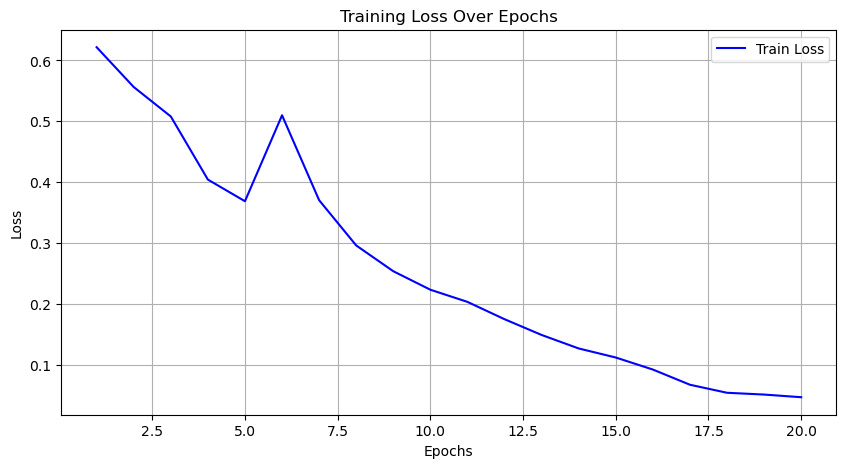

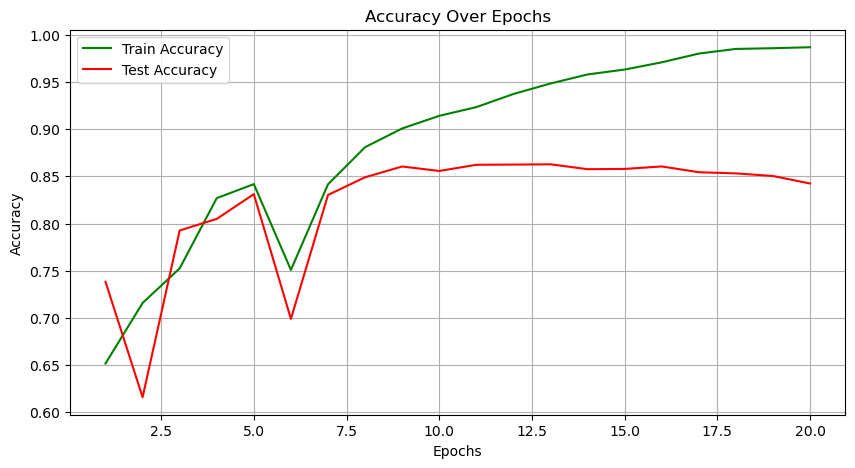

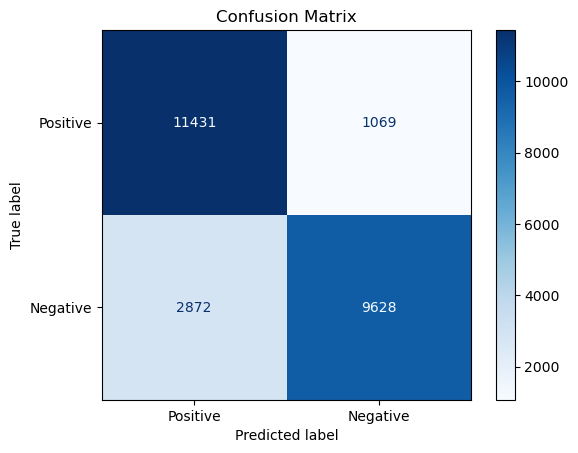

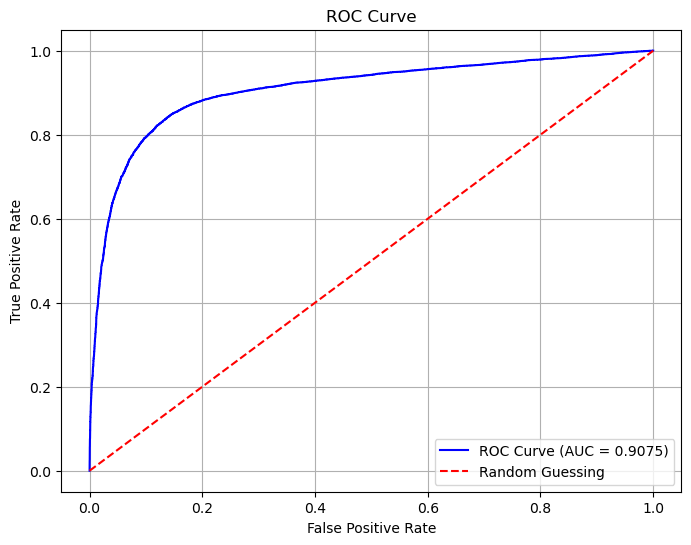

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import os
import glob
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc
)

# 检查是否有可用的 GPU，优先使用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据集类，用于将文本和标签封装为可迭代的 Dataset 对象
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        """
        :param texts: 文本列表，每个文本是一个单词列表
        :param labels: 标签列表，0 表示正面情感，1 表示负面情感
        :param vocab: 词汇表，单词到索引的映射
        """
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
    
    def __len__(self):
        """返回数据集的样本数量"""
        return len(self.labels)
    
    def __getitem__(self, idx):
        """
        获取指定索引的数据，包括文本的索引序列和对应的标签
        :param idx: 数据索引
        """
        # 将文本中的单词转换为对应的索引，未出现在词汇表中的单词将被忽略
        text = [self.vocab[word] for word in self.texts[idx] if word in self.vocab]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# 数据预处理函数，读取文本文件并分词
def preprocess_data(data_dir):
    """
    读取指定目录下的数据，并为每个样本分配标签
    :param data_dir: 数据文件的根目录
    :return: 文本列表和标签列表
    """
    texts = []
    labels = []
    for label in ["pos", "neg"]:  # 遍历正面和负面影评目录
        file_paths = glob.glob(os.path.join(data_dir, label, "*.txt"))  # 获取文件路径
        for file_path in file_paths:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
                texts.append(text.lower().split())  # 将文本分词并转为小写
                labels.append(0 if label == "pos" else 1)  # 正面为 0，负面为 1
    return texts, labels

# 定义 LSTM 模型
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout_prob):
        """
        :param vocab_size: 词汇表大小
        :param embed_dim: 嵌入层维度
        :param hidden_dim: LSTM 隐藏层维度
        :param num_layers: LSTM 层数
        :param num_classes: 输出类别数
        :param dropout_prob: Dropout 概率
        """
        super(LSTMClassifier, self).__init__()
        # 嵌入层，将单词索引映射为嵌入向量
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # LSTM 层，用于处理序列数据
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        # Dropout 层，用于防止过拟合
        self.dropout = nn.Dropout(dropout_prob)
        # 全连接层，将 LSTM 的输出映射为类别分数
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, text, lengths):
        """
        前向传播函数
        :param text: 文本的索引序列
        :param lengths: 文本序列的原始长度
        """
        # 嵌入层，将单词索引映射为嵌入向量
        embedded = self.embedding(text)
        # 使用 pack_padded_sequence 优化 LSTM 的计算效率
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        # LSTM 前向传播
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # 获取最后一层的隐藏状态
        hidden = self.dropout(hidden[-1])
        # 全连接层输出类别分数
        out = self.fc(hidden)
        return out

# 超参数设置
embed_dim = 128  # 嵌入层维度
hidden_dim = 256  # 隐藏层维度
num_layers = 2  # LSTM 层数
num_classes = 2  # 输出类别数（正面或负面）
batch_size = 64  # 每个批次的样本数
num_epochs = 20  # 训练的总轮数
learning_rate = 0.0005  # 学习率
dropout_prob = 0.1  # Dropout 概率
weight_decay = 1e-5  # L2 正则化系数

# 数据路径设置
train_data_dir = "./aclImdb/train"
test_data_dir = "./aclImdb/test"

# 数据加载与处理
train_texts, train_labels = preprocess_data(train_data_dir)
test_texts, test_labels = preprocess_data(test_data_dir)

# 构建词汇表，使用 CountVectorizer 提取词汇
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit([" ".join(text) for text in train_texts])
vocab = {word: i+1 for i, word in enumerate(vectorizer.get_feature_names_out())}  # 单词索引从 1 开始

# 构建数据集
train_dataset = IMDBDataset(train_texts, train_labels, vocab)
test_dataset = IMDBDataset(test_texts, test_labels, vocab)

# 定义 DataLoader
def collate_fn(batch):
    """
    自定义批处理函数
    :param batch: 当前批次的数据
    :return: 填充后的文本序列、标签和原始长度
    """
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)  # 序列长度
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # 填充序列
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels, lengths

# 数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 初始化模型
vocab_size = len(vocab) + 1  # 词汇表大小（包含填充索引 0）
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout_prob).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

# 初始化记录列表
train_losses = []
train_accuracies = []
test_accuracies = []

# 训练模型
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels, lengths in train_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
    
    # 保存训练损失和准确率
    train_losses.append(total_loss / len(train_dataloader))
    train_accuracies.append(total_correct / len(train_dataset))
    
    # 测试模型
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for texts, labels, lengths in test_dataloader:
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()
            outputs = model(texts, lengths)
            total_correct += (outputs.argmax(1) == labels).sum().item()
    
    test_accuracies.append(total_correct / len(test_dataset))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

# 绘制训练损失趋势
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# 绘制训练和测试准确率趋势
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# 测试模型
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels, lengths in test_dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.cpu()
        outputs = model(texts, lengths)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC 曲线
all_probs = []
with torch.no_grad():
    for texts, labels, lengths in test_dataloader:
        texts = texts.to(device)
        outputs = model(texts, lengths)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [ ]:
import os
import glob

# 数据预处理函数，读取数据并分词
def preprocess_data(data_dir):
    """
    该函数用于加载IMDB数据集中的电影评论数据 并对文本进行分词及标签化。
    
    参数：
    - data_dir: 数据集文件夹路径
    
    返回：
    - texts: 评论文本的列表
    - labels: 评论标签的列表 正面评论为0 负面评论为1
    """
    texts = []  # 存储评论文本
    labels = []  # 存储评论标签（0: 正面，1: 负面）
    
    # 遍历"pos"（正面评论）和"neg"（负面评论）文件夹
    for label in ["pos", "neg"]:
        # 获取当前标签下的所有文本文件路径
        file_paths = glob.glob(os.path.join(data_dir, label, "*.txt"))
        
        # 遍历每一个评论文件
        for file_path in file_paths:
            # 打开并读取评论文件内容
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()  # 去掉文本两端的空白字符
                texts.append(text)  # 将评论文本添加到 texts 列表
                # 根据标签添加相应的标签（0: 正面，1: 负面）
                labels.append(0 if label == "pos" else 1)
    
    return texts, labels  # 返回文本和标签列表

# 示例：加载训练集和测试集数据
train_data_dir = "./aclImdb/train"  # 训练集路径
test_data_dir = "./aclImdb/test"    # 测试集路径

# 调用预处理函数加载数据
train_texts, train_labels = preprocess_data(train_data_dir)  # 训练集文本和标签
test_texts, test_labels = preprocess_data(test_data_dir)     # 测试集文本和标签